In [59]:
import matplotlib
import os
import csv
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [60]:
thermal_losses = pd.read_csv(r'..\data\energy_demands\thermal_losses_testset.csv')
y_test = np.array(thermal_losses.loc[:,'Qs-Qi(Wh)':].values)
thermal_losses = None

inputs_thermal = pd.read_csv(r'..\data\inputs\inputs_thermal_testset.csv')
X_test = np.array(inputs_thermal.loc[:,'G_Dh':].values)
inputs_thermal = None

inputs_thermal_aux = pd.read_csv(r'..\data\inputs\inputs_thermal.csv')
X_aux = np.array(inputs_thermal_aux.loc[:,'G_Dh':].values)
inputs_thermal_aux = None

In [61]:
#Scaling the data (substracting mean and dividing by the standard deviation)
X_test = np.divide((X_test-X_aux.mean(axis=0)),(X_aux.std(axis=0)))
X_aux = None

In [62]:
class Net(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape[1], 25)
        self.bn1 = nn.BatchNorm1d(num_features=25)
        self.fc2 = nn.Linear(25,12)
        self.bn2 = nn.BatchNorm1d(num_features=12)
        self.fc3 = nn.Linear(12, output_shape[1])
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

In [63]:
device = 'cpu'
net = Net(X_test.shape, y_test.shape).to(device)
criterion = torch.nn.MSELoss()

In [64]:
X_test_torch = torch.tensor(X_test, device='cpu').float()
y_test_torch = torch.tensor(y_test, device='cpu').float()

In [65]:
PATH = r'..\results\dnn12'
net.load_state_dict(torch.load(PATH))
net.eval()
start = time.time()
y_pred = net(X_test_torch)
end = time.time()
print(end - start)

2.5591723918914795


In [66]:
loss = criterion(y_pred, y_test_torch)

print(loss.item(), r2_score(y_test_torch.data.numpy(),y_pred.data.numpy()))

2870672128.0 0.8500736540089907


In [67]:
mean_squared_error(y_test_torch.data.numpy(),y_pred.data.numpy())

2870672400.0

In [68]:
mean_absolute_error(y_test_torch.data.numpy(),y_pred.data.numpy())

24125.521

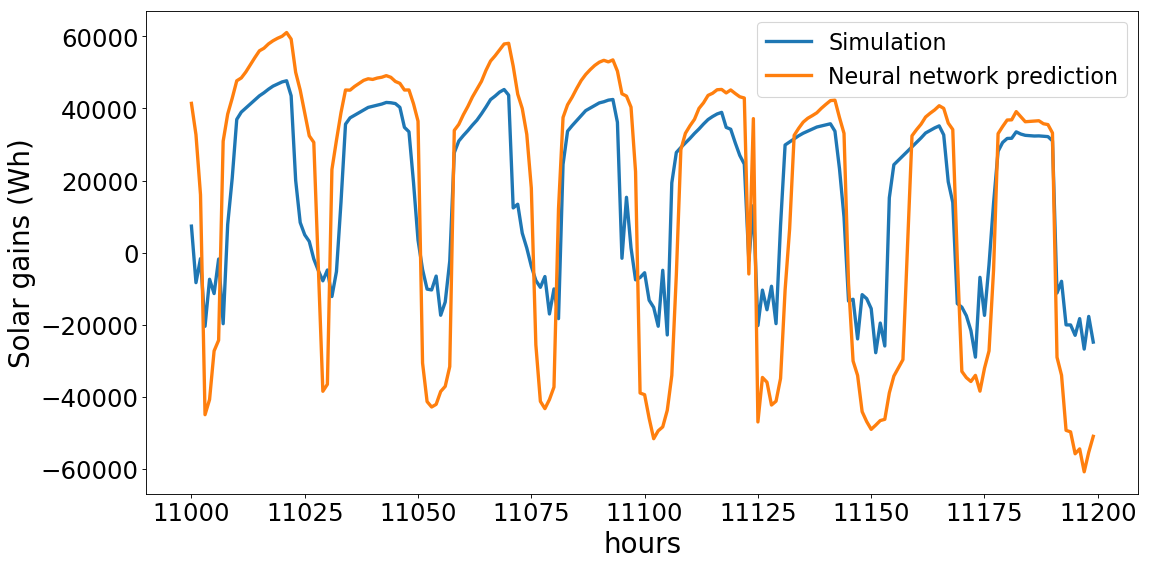

In [69]:
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22)
plt.plot(list(range(11000,11200)), y_test_torch[11000:11200].data.numpy(),linewidth=3.0)
plt.plot(list(range(11000,11200)), y_pred[11000:11200].data.numpy(),linewidth=3.0)
plt.legend(['Simulation','Neural network prediction'], fontsize=20)
plt.xlabel('hours', fontsize=25)
plt.ylabel('Solar gains (Wh)', fontsize=25)

plt.savefig('solar_gains.png', dpi=600)